In [52]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn
from sklearn.impute import SimpleImputer    
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [53]:
np.random.seed(448)

## Part 1

### Data linkage without blocking

After testing, it was decided that manufacturer and description should not be used in linkage as this lead to too much variance in results. 

A jaccard index, which is used to measure the overlap of two strings, was used to compare the strings in order to get a score based on the similarity of the titles, this was used as titles/names will usually be quite similar across platforms and the jaccard index will usually lead to accurate results while measuring short titles such as the ones in these datasets.

to calculate the similarity of the prices, i took the minimum value of the two and divided that by the maximum value of the two, this leads to creating a (smaller than one) score based on how much smaller the first number is from the second.

The final score was decided by summing the name score and half the price score. The reason half the price score was used was due to it being a less accurate representation of similarity (multiple items can have the same/similar price) in comparison to name which will very rarely have the same/similar values.

The threshold for determining the scores was done through trial and error in order to get the best balance between precision and recall. We also only accounted for the idAmazon's with the highest final scores when comparing with our truth dataset as there can only be one true match for each id, this sufficienty improved the performance of our linkage.

The performance shows us precision ~ 0.915 and recall ~ 0.908. These values both appear to be very good as we have a very high rate of correct linkage between our datasets while still covering a large amount of the true values. 

In [8]:
# read in all the needed files
google_products = pd.read_csv('google_small.csv')
amazon_products = pd.read_csv('amazon_small.csv')
true = pd.read_csv('amazon_google_truth_small.csv').sort_values(by='idAmazon')

In [9]:
def get_jaccard_sim(str1, str2):
    """
    Get the Jaccard similarity score between two strings
    """
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [10]:
# set a common column for merge
google_products['key'] = 1
amazon_products['key'] = 1

In [11]:
# join the 2 dataframes
joined = pd.merge(google_products, amazon_products, on='key').drop('key', axis=1)
# calculate the scores for the names/titles using the jaccard index
joined['name_score'] =joined.apply(lambda row: get_jaccard_sim(row['name'], row['title']), axis=1)
# calculate the scores for the price similarities
joined['price_score'] = joined.apply(lambda row: (min(row['price_x'], row['price_y'])/max(row['price_x'], row['price_y'])), axis=1)
# calculate the final scores with the price weighted less as there is more chance of duplicates
joined['final_score'] = joined['name_score'] + joined['price_score']/2

In [12]:
# threshold determined through trial and error, only concerned with values above this threshold
THRESHOLD = 0.54
joined = joined[joined['final_score'] > THRESHOLD]
# take only the largest score for each amazonID for comparison
joined = joined.sort_values(by='final_score', ascending=False).drop_duplicates(['idAmazon'])
# create new dataframes for faster calculations
predicted = joined.loc[:, ['idAmazon', 'idGoogleBase']].sort_values(by='idAmazon')

In [13]:
# create a dataframe of tp values
tp_values = []
tp_df = predicted.merge(true, on=['idAmazon', 'idGoogleBase'])
tp_df.head()

,idAmazon,idGoogleBase
0,1931102953,http://www.google.com/base/feeds/snippets/1272...
1,b00002s6sc,http://www.google.com/base/feeds/snippets/1049...
2,b00004nhn7,http://www.google.com/base/feeds/snippets/1843...
3,b000051sgq,http://www.google.com/base/feeds/snippets/1758...
4,b000067fk7,http://www.google.com/base/feeds/snippets/3785...


In [14]:
# calculate precision and recall using tp, fp, fn
tp = len(tp_df)
fp = len(predicted) - tp
fn = len(true) - tp
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f'precision = {precision}')
print(f'recall = {recall}')

precision = 0.9147286821705426
recall = 0.9076923076923077


## Data linkage with blocking
It was decided to use a blocking method based on price ranges. This was decided by somewhat of a trial and error process, as well as deduction, I originally attempted to block with n-grams on title but this lead to having far too many blocks and turned out to be a poor way to block these datasets. The sizes of the price blocks were determined by prior knowledge of how items are generally priced and the largest block size was determined by calling .max() on the prices of both dataframes. I also decided to not impute the 0 values of price in the amazon.csv file to anything, this is because imputing it to the mean/median would be improper as we are solely blocking on price and there is large variance in prices.

This blocking method seemed to work quite well, both the PC and RR are around 80% which is quite high. These results are not as good as the results produced from the measures in the naive-linkage implemented earlier but this is to be expected as blocking is generally a less precise method as it prioritises speed and security over results. If a naive linkage method was used here, it would be very slow as there are millions of possible combinations between the datasets, using blocking significantly sped up the process.

pair completeness measures the coverage of our values from within the truth dataset, with our value being ~80%, we have quite a good recall considering that blocking was used this could potentially be increased further by adding a second conjunction to the blocking scheme. Reduction ratio is a measure of the effectiveness of data reduction, here we also have a value of ~80% which means that we have a high ratio of data ingested to data matched.


In [15]:
# create dataframes from datasets
google_products = pd.read_csv('google.csv')
amazon_products = pd.read_csv('amazon.csv')
true = pd.read_csv('amazon_google_truth.csv')
true = true.rename(columns={'idGoogleBase':'id'})

In [16]:
# preprocess price data
# assume prices are in gbp already so no need to apply exchange rate
google_products['price'] = google_products['price'].str.replace('gbp', '')
amazon_products['price'] = amazon_products['price'].replace('gbp', '')
google_products['price'] = pd.to_numeric(google_products['price'])
amazon_products['price'] = pd.to_numeric(amazon_products['price'])
amazon_products['price'].max()

101515.55

In [17]:
# create blocks and labels for price and allocate each id to a block
blocks = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 100000, 1000000]
labels = list(range(1,12))
amazon_products['bin'] = pd.cut(amazon_products.price, bins=blocks, include_lowest=True, labels=labels)
google_products['bin'] = pd.cut(google_products.price, bins=blocks, include_lowest=True, labels=labels)

In [18]:
# create a common column to merge on
google_products['key'] = 1
amazon_products['key'] = 1

matches = []
fp = 0

# find matches within the ground truth and each block
for i in labels:
    amazon = amazon_products.loc[amazon_products['bin'] == i]
    google = google_products.loc[google_products['bin'] == i]
    joined = pd.merge(google, amazon, on='key').drop('key', axis=1).loc[:, ['id', 'idAmazon']]
    df = joined.merge(true, on=['idAmazon', 'id'])
    fp += (len(joined) - len(df))
    matches.append(df)
                
matches = pd.concat(matches)
matches.head()

,id,idAmazon
0,http://www.google.com/base/feeds/snippets/1056...,b000aoz7hw
1,http://www.google.com/base/feeds/snippets/1290...,b000hcl5sm
2,http://www.google.com/base/feeds/snippets/1823...,b000jx1kgq
3,http://www.google.com/base/feeds/snippets/1826...,b000h25yr0
4,http://www.google.com/base/feeds/snippets/1825...,b0009yegpc


In [19]:
# calculate PC and RR
tp = len(matches)
fn = len(true) - tp
PC = tp/(tp+fn)
n = len(amazon_products)*len(google_products)
RR = 1-(tp+fp)/n
print(f'Pair completeness = {PC}')
print(f'Reduction ratio = {RR}')

Pair completeness = 0.7876923076923077
Reduction ratio = 0.8019180184478734


## Part 2

Since the column `Sample` is just an incremntal ID of the observation, we have not included it in the analysis. When including the column `pox` the bin width would be very small. As this is not practical when compared to the other columns (which require wider bin widths and more bins), we have excluded the column from any further analysis.

### Pre-processing discussion
From the distribution of the original dataset it is apparent that the majority of the data lies within range with a width of `0.1`. As a result, choosing median imputation would be favourable since outliers would not have as much affect with this strategy as opposed to mean imputation.

### Comparing Classification Algorithms

The aim is to find the classifying method that performs the best on the test data without either overfitting or underfitting on the training data.

To achieve this goal we initially normalised the data by fitting the data to a standard noraml distribution. Then the results were used to train three different clissifying model:

- KNN with 5 neighbours
- KNN with 10 neighbours
- decision tree classifier

The classifier used at each stage was thr normal unmodified classifier offered by the library. This helped ensure consistency for the k_means classifiers as no other parameter but the number of neighbours was changed.

Accuracies on training data:
- 0.8098591549295775 for KNN with 5 neigbhours
- 0.772635814889336 for KNN with 10 neighbours
- 0.9849094567404426 for decision tree classifier

Accuracies on test data:
- 0.6816326530612244 for KNN with 5 neighbours
- 0.6693877551020408 for KNN with 10 neighbours
- 0.6714285714285714 for decision tree classifier


The score for the dtc obtained on the training data suggests that the classifier is overly fitted to the training data. This implies that there is a high chance of the claddifier performing exceptionally on the test data but failing to predict feasible values on test data which it was not fitted to. The consequence of this is apparent on the results demonstrated above. The decision tree classifier performed well on the training data with a score of 0.98 whereas the test data only scored 0.67 which is clearly much lower than the training score.

After multiple trials, it became evident that the results for the score were in the neighberhood of 0.67 and all of the classification methods seem to have achieved the same score of 0.67. Therefore, there is no clear advantage to any of the algorithms if all the parameters are set to their default settings from the parent library.

## Feature Engineering




In [20]:
# all the constants for part 2
OPTIMAL_BIN_VALUE = 9

In [23]:
yeast_data = pd.read_csv('all_yeast.csv')
yeast_data['Class'] = yeast_data.Class.replace(to_replace=yeast_data.Class.unique(), value=[0, 1])

In [24]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yeast_data.drop(['Class', 'pox', 'Sample'], axis=1), yeast_data['Class'], test_size=0.33)
X_train_mean = pd.DataFrame(mean_imputer.fit_transform(X_train))
X_train_median = pd.DataFrame(median_imputer.fit_transform(X_train))


X_test_mean = pd.DataFrame(mean_imputer.fit_transform(X_test))
X_test_median = pd.DataFrame(median_imputer.fit_transform(X_test))

In [26]:
X_train_mean.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.497065,0.499804,0.498758,0.263763,0.509279,0.506622,0.275350
std,0.132575,0.123718,0.080742,0.155979,0.109570,0.182452,0.104874
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.140000,0.000000
25%,0.410000,0.420000,0.470000,0.170000,0.500000,0.480000,0.220000
50%,0.497065,0.490000,0.500000,0.230000,0.500000,0.510000,0.220000
75%,0.560000,0.570000,0.550000,0.300000,0.500000,0.530000,0.280000
max,1.000000,1.000000,0.790000,3.000728,3.500849,6.001456,1.000000


In [27]:
X_train_median.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.495503,0.499577,0.499708,0.259669,0.509055,0.506812,0.272565
std,0.132667,0.123727,0.080803,0.156499,0.109579,0.182454,0.105570
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.140000,0.000000
25%,0.410000,0.420000,0.470000,0.170000,0.500000,0.480000,0.220000
50%,0.480000,0.490000,0.510000,0.220000,0.500000,0.510000,0.220000
75%,0.560000,0.570000,0.550000,0.300000,0.500000,0.530000,0.280000
max,1.000000,1.000000,0.790000,3.000728,3.500849,6.001456,1.000000


In [28]:
stdscl = StandardScaler(with_mean=True, with_std=True)

In [29]:
X_train_std = pd.DataFrame(stdscl.fit_transform(X_train_median))
X_train_norm = pd.DataFrame(normalize(X_train_median))

X_test_std = pd.DataFrame(stdscl.fit_transform(X_test_median))
X_test_norm = pd.DataFrame(normalize(X_test_median))

In [30]:
X_train_std.describe()

,0,1,2,3,4,5,6
count,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02
mean,-1.992593e-16,-3.413321e-16,-6.683677e-16,-7.148317e-17,4.378344e-16,5.146788e-16,-5.128918e-16
std,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00
min,-2.907268e+00,-2.988542e+00,-3.587171e+00,-1.660068e+00,-8.267739e-02,-2.011451e+00,-2.583151e+00
25%,-6.448203e-01,-6.434933e-01,-3.678479e-01,-5.732543e-01,-8.267739e-02,-1.470280e-01,-4.981716e-01
50%,-1.169159e-01,-7.744698e-02,1.274326e-01,-2.536031e-01,-8.267739e-02,1.747990e-02,-4.981716e-01
75%,4.864035e-01,5.694631e-01,6.227131e-01,2.578387e-01,-8.267739e-02,1.271518e-01,7.045910e-02
max,3.804660e+00,4.046605e+00,3.594396e+00,1.752365e+01,2.731627e+01,3.013041e+01,6.894028e+00


In [31]:
X_train_norm.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.406754,0.411189,0.416882,0.211212,0.422778,0.419086,0.226347
std,0.083601,0.080846,0.075656,0.098537,0.050995,0.057508,0.081494
min,0.052470,0.044185,0.095172,0.000000,0.082045,0.135317,0.000000
25%,0.355770,0.361875,0.371220,0.145633,0.394632,0.389207,0.179835
50%,0.406271,0.412508,0.424963,0.184441,0.420554,0.423383,0.200083
75%,0.456992,0.459549,0.468125,0.247616,0.446981,0.453539,0.246813
max,0.686168,0.700569,0.617031,0.949385,0.966781,0.984776,0.675441


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [33]:
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn = KNeighborsClassifier(n_neighbors=5)
dtc = DecisionTreeClassifier(criterion='gini', max_depth=3)

In [34]:
X_train = X_train_norm
X_test = X_test_norm

In [35]:
knn.fit(X_train, y_train)
score_train_knn = knn.score(X_train, y_train)
score_test_knn = knn.score(X_test, y_test)



knn_10.fit(X_train, y_train)
score_train_knn_10 = knn_10.score(X_train, y_train)
score_test_knn_10 = knn_10.score(X_test, y_test)

In [36]:
print(score_train_knn, "   training k = 5")
print(score_test_knn, "   test k = 5")


print(score_train_knn_10, "   training k = 10")
print(score_test_knn_10, "   test k = 10")

0.7927565392354124    training k = 5
0.6755102040816326    test k = 5
0.7756539235412475    training k = 10
0.6938775510204082    test k = 10


In [37]:
from sklearn.preprocessing import KBinsDiscretizer
def dtc_fitting(X_train, X_test, num_bins):
    """
    Create bins then fit DTC
    """
    
    enc = KBinsDiscretizer(n_bins=num_bins, encode='ordinal')


    X_binned = enc.fit_transform(X_train)
    X_binned_test = enc.transform(X_test)

    dtc.fit(X_binned, y_train)
    score_dtc = dtc.score(X_binned, y_train)
    score_test_dtc = dtc.score(X_binned_test, y_test)
    return score_dtc, score_test_dtc

In [38]:
score_dtc, score_test_dtc = dtc_fitting(X_train, X_test, 9)
print("best score value for the training set is: ", score_dtc)
print("best score value for the test set is: ", score_test_dtc)

best score value for the training set is:  0.7263581488933601
best score value for the test set is:  0.689795918367347


In [39]:
def pair_interaction_featurize(X):
    """
    Generate pair interaction features from a dataframe
    """
    features_multiplied = pd.DataFrame()
    for i in X:
        for j in X:
            if int(j) > int(i):
                col1 = pd.Series(X[i])
                col2 = pd.Series(X[j])
                col1 = col1.mul(col2)
                features_multiplied[int(str(i) + str(j))] = col1 
    generated_features = pd.concat([features_multiplied, X], axis=1)
    return features_multiplied

         
X_train_interaction_pair = pair_interaction_featurize(X_train)
X_test_interaction_pair = pair_interaction_featurize(X_test)

In [40]:
from sklearn.feature_selection import mutual_info_classif

enc_mi = KBinsDiscretizer(n_bins = OPTIMAL_BIN_VALUE, encode = "ordinal")
X_binned_mi = enc_mi.fit_transform(X_train_interaction_pair)
X_binned_test_mi = enc_mi.fit_transform(X_test_interaction_pair)

mutual_info_classifier = mutual_info_classif(X_binned_mi, y_train)

entropy_with_index = sorted([(index, el) for index, el in zip(mutual_info_classifier, X_train_interaction_pair.columns)], key=lambda x: x[0], reverse=True)

In [41]:
scores_train = []
scores_test = []
for i in range(1, len(entropy_with_index)):
    columns = [i[1] for i in entropy_with_index[0:i]]
    knn_10.fit(X_train_interaction_pair[columns], y_train)
    score_train  = knn_10.score(X_train_interaction_pair[columns], y_train)
    score_test  = knn_10.score(X_test_interaction_pair[columns], y_test)
    scores_train.append(score_train)
    scores_test.append(score_test)

0.7142857142857143 test score


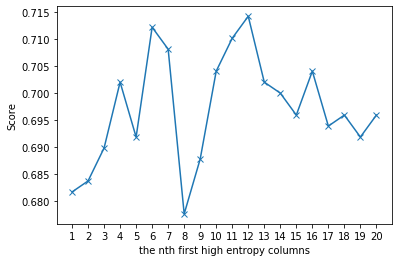

In [42]:
range_n = range(1, len(entropy_with_index))    
op = plt.plot(range_n, scores_test)
plt.setp(op,'marker', 'x')
plt.xlabel("the nth first high entropy columns")
plt.xticks(range_n)
plt.ylabel("Score")
print(max(scores_test), "test score")
plt.show()

In [43]:
def kmeans_interaction_featurize(X, X_binned):
    kmeans = []
    KMEANS_RANGE = 16
    generated_features_kmeans = pd.DataFrame()
    for i in range(2, KMEANS_RANGE):
        kmeans.append(KMeans(n_clusters=i, random_state = 0).fit(X))
        generated_features_kmeans[int(str(1) + str(i))] = kmeans[i-2].predict(X)
    generated_features_kmeans = pd.concat([generated_features_kmeans, X_binned], axis=1)
    return generated_features_kmeans

In [44]:
from sklearn.cluster import KMeans
X_binned_kmeans = enc_mi.fit_transform(X_train)
X_binned_test_kmeans = enc_mi.fit_transform(X_test)

In [45]:
enc_mi = KBinsDiscretizer(n_bins = OPTIMAL_BIN_VALUE, encode = "ordinal")
X_binned_mi = pd.DataFrame(enc_mi.fit_transform(X_train))
X_binned_test_mi = pd.DataFrame(enc_mi.fit_transform(X_test))

In [46]:
X_train_kmeans = kmeans_interaction_featurize(X_train, X_binned_mi)
X_test_kmeans = kmeans_interaction_featurize(X_test, X_binned_test_mi)

In [47]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_classifier = mutual_info_classif(X_train_kmeans, y_train)
entropy_with_index = sorted([(index, el) for index, el in zip(mutual_info_classifier, X_train_kmeans.columns)], key=lambda x: x[0], reverse=True)

entropy_with_index

[(0.09147829900940185, 114),
 (0.08911601726359919, 115),
 (0.08795047818944846, 112),
 (0.0726095017529702, 110),
 (0.06745855781516186, 2),
 (0.06566997924889328, 17),
 (0.06211955740920261, 111),
 (0.060380780280446356, 113),
 (0.058830390141064504, 18),
 (0.04147411216344232, 4),
 (0.03859691325107928, 16),
 (0.03022645092854659, 19),
 (0.029400710053849366, 6),
 (0.02831805295485368, 15),
 (0.01595135614188692, 12),
 (0.013286933339639928, 5),
 (0.01094975552803601, 1),
 (0.009343603064364103, 0),
 (0.007641600809197735, 3),
 (0.0046348525316779465, 14),
 (0.0, 13)]

In [48]:
scores_train_kmeans = []
scores_test_kmeans = []
for i in range(1, len(entropy_with_index)):
    columns = [i[1] for i in entropy_with_index[0:i]]
    knn_10.fit(X_train_kmeans[columns], y_train)
    score_train_kmeans  = knn_10.score(X_train_kmeans[columns], y_train)
    score_test_kmeans  = knn_10.score(X_test_kmeans[columns], y_test)
    scores_train_kmeans.append(score_train_kmeans)
    scores_test_kmeans.append(score_test_kmeans)
    

0.7122448979591837 test score


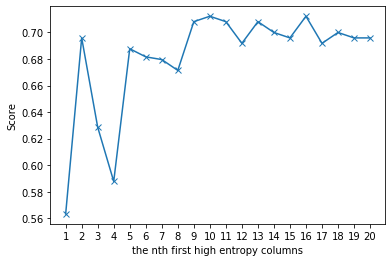

In [49]:
import matplotlib.pyplot as plt
range_n = range(1, len(entropy_with_index))    
op = plt.plot(range_n, scores_test_kmeans)
plt.setp(op,'marker', 'x')
plt.xlabel("the nth first high entropy columns")
plt.xticks(range_n)
plt.ylabel("Score")
print(max(scores_test_kmeans), "test score")
plt.show()

In [50]:
#test scores comparison
print(score_test_knn, " noraml knn 5")
print(score_test_knn_10, " noraml knn 10")
print(max(scores_test), " feature multiplied")
print(max(scores_test_kmeans), " feature kmeans")

0.6755102040816326  noraml knn 5
0.6938775510204082  noraml knn 10
0.7142857142857143  feature multiplied
0.7122448979591837  feature kmeans
